Решить методами Гаусса и Зейделя, найти $\lambda_{min}$ и $\lambda_{max}$, определить число обусловленности матрицы $\mu = \|A\| \cdot \|A^{-1}\|$. Сделать печать невязок обоих методов. Указать критерий останова итераций метода Зейделя.

In [1]:
from math import sqrt, inf
import numpy as np
from numpy.linalg import cond, eigvals, inv, norm

import matplotlib.pyplot as plt
%matplotlib inline

ITERATION_LIMIT = 1000

In [2]:
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

a = [1] * 98
b = [10+i for i in range(1, 100)]
c = [1] * 98

A = tridiag(a, b, c)
A[-1] = [1] + [2] * 97 + [1]

b = np.array([i/99. for i in range(1, 100)])

extended_A = np.hstack((A, b.reshape(-1, 1)))

print(np.matrix(A))
print(A.shape)

[[ 11   1   0 ...   0   0   0]
 [  1  12   1 ...   0   0   0]
 [  0   1  13 ...   0   0   0]
 ...
 [  0   0   0 ... 107   1   0]
 [  0   0   0 ...   1 108   1]
 [  1   2   2 ...   2   2   1]]
(99, 99)


Посмотрим на собственные числа и обусловленность матрицы

In [10]:
print(max(np.linalg.eigvals(K)).real, min(np.linalg.eigvals(K)).real)

0.020820398028589884 -0.018655700527825145


$\lambda_{max} \approx 0.0208,\ \lambda_{min} \approx -0.0187$

In [11]:
print('Число обусловленности: ', cond(A))

Число обусловленности:  124.81872840465405


## 1. Метод Гаусса

In [5]:
def triu_gauss(A, m):
    x = np.ones(m)
    for i in range(m-1, -1, -1):
        x[i] = A[i][m] / A[i][i]
        for j in range(i-1, -1, -1):
            A[j][m] -= A[j][i] * x[i]
    return x

def gauss(A_b):
    m = len(A_b)
    for k in range(m):
        for i in range(k + 1, m):
            coef = A_b[i][k] / A_b[k][k]
            for j in range(k + 1, m + 1):
                A_b[i][j] -= A_b[k][j] * coef
            A_b[i][k] = 0
    return triu_gauss(A_b, m)

In [6]:
x_gauss = gauss(extended_A.copy())
error_gauss = np.dot(A, x_gauss) - b

# print('Решение: ', x_gauss)
# print('Невязка: ', error_gauss)
print('Норма невязки: ', norm(error_gauss))

Норма невязки:  6.10188828559375e-16


## 2. Метод Зейделя

In [7]:
def seidel(A, b, eps=1e-10, verbose=False, max_iter=ITERATION_LIMIT):
    q = norm(K, 2)
    if q >= 1:
        raise ValueError("Норма матрицы={} > 1, не применим оптимальный критерий останова".
                        format(q))    

    n = len(A)
    x = np.zeros_like(b)
    
    for j in range(1, max_iter):
        x_new = np.copy(x)
        for i in range(n):
            s1 = sum(A[i][j] * x_new[j] for j in range(i))
            s2 = sum(A[i][j] * x[j] for j in range(i + 1, n))
            x_new[i] = (b[i] - s1 - s2) / A[i][i]

        if q ** j / (1-q) < eps:
            if verbose:
                print('Потребовалось ', j, ' итераций')
            return x_new
        x = x_new
    
    raise ValueError("Не сходится за данное число итераций")

In [8]:
x_seidel = seidel(A, b, eps=1e-16, verbose=True)
error_seidel = np.dot(A, x_seidel) - b

# print('Решение: ', x_seidel)
# print('Невязка: ', error_seidel)
print('MAE невязки: ', norm(error_seidel))

Потребовалось  62  итераций
MAE невязки:  5.857100574038117e-16


Посмотрим, как зависит норма невязки от значений $\varepsilon$

In [14]:
tols = np.linspace(1e-15, 0.01, 1000)
maes = [norm(np.dot(A, seidel(A, b, eps=tol)) - b) for tol in tols]

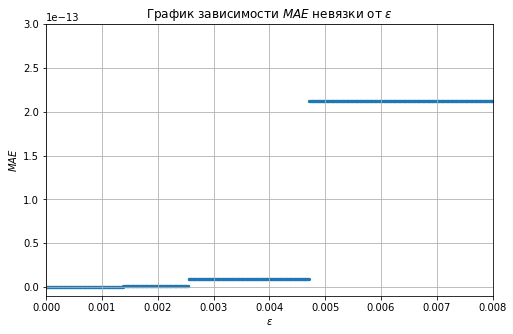

In [43]:
plt.figure(figsize=(8, 5))
plt.title("График зависимости $MAE$ невязки от $\\varepsilon$")
plt.xlabel('$\\varepsilon$')
plt.ylabel('$MAE$')
plt.ylim(-1e-14, 3e-13)
plt.xlim(0, 8e-3)
plt.grid()
plt.scatter(tols, maes, s=5);

Сходимость имеет ступенчатый вид, причём видно, что на нашей системе алгоритм очень быстро приблизился к точному решению 

## 3. Метод последовательной верхней релаксации

$$\mathbf {x} ^{(k+1)}=(D+\omega L)^{-1}{\big ((1 - \omega)D - \omega U {\big )}\mathbf {x} ^{(k)} + \omega (D+\omega L)^{-1}} \mathbf {b} = K\mathbf {x} ^{(k)} + F$$

In [45]:
def relaxation(A, b, w, verbose=False, max_iter=ITERATION_LIMIT, return_val='x'):
    L = np.tril(A, k=-1)
    D = np.diag(np.diag(A))
    U = np.triu(A, k=1)

    Q = np.linalg.inv(D + w * L)
    K = np.dot(Q,((1.0 - w) * D - w * U))
    F = w*np.dot(Q, b)
    
    q = norm(K, 2)
    if q >= 1:
        raise ValueError("Норма матрицы={} > 1, не применим оптимальный критерий останова".
                        format(q))
    
    x = np.zeros_like(b)
    x_1 = np.dot(K, x) + F
    n = len(b)
    for j in range(1, max_iter):
        x_new = np.dot(K, x) + F
        if q ** j / (1-q) < 1e-15:
            if verbose:
                print('Потребовалось ', j, ' итераций')
            if return_val == 'x':
                return x
            elif return_val == 'j':
                return j
        x = x_new
    raise ValueError("Не сходится за данное число итераций")

Найдём оптимальное $w$ простым перебором от 1.0 до 1.2 (после $w=1.02$ алгоритм перестаёт сходиться)

In [46]:
for i in np.linspace(1., 1.02, 200):
    print(i, '\t - \t', relaxation(A, b, i, return_val='j'))

1.0 	 - 	 58
1.0001005025125629 	 - 	 58
1.0002010050251255 	 - 	 59
1.0003015075376884 	 - 	 59
1.0004020100502513 	 - 	 59
1.000502512562814 	 - 	 60
1.0006030150753769 	 - 	 60
1.0007035175879397 	 - 	 60
1.0008040201005026 	 - 	 61
1.0009045226130653 	 - 	 61
1.0010050251256282 	 - 	 61
1.001105527638191 	 - 	 62
1.0012060301507537 	 - 	 62
1.0013065326633166 	 - 	 62
1.0014070351758795 	 - 	 63
1.0015075376884421 	 - 	 63
1.001608040201005 	 - 	 63
1.001708542713568 	 - 	 64
1.0018090452261306 	 - 	 64
1.0019095477386935 	 - 	 64
1.0020100502512563 	 - 	 65
1.002110552763819 	 - 	 65
1.0022110552763819 	 - 	 65
1.0023115577889448 	 - 	 66
1.0024120603015076 	 - 	 66
1.0025125628140703 	 - 	 66
1.0026130653266332 	 - 	 67
1.002713567839196 	 - 	 67
1.0028140703517587 	 - 	 68
1.0029145728643216 	 - 	 68
1.0030150753768845 	 - 	 68
1.0031155778894472 	 - 	 69
1.00321608040201 	 - 	 69
1.003316582914573 	 - 	 70
1.0034170854271356 	 - 	 70
1.0035175879396985 	 - 	 70
1.00361809045226

С ростом $w$ число итераций только растёт, то есть оптимально здесь $w$, близкое к 1. При этом метод релаксации превращается итерационный процесс, эквивалентный методу Зейделя. То есть в данной задаче этот метод не даёт существенных выгод.